In [ ]:
import sys
sys.path.append('../')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle


import CONFIG

In [3]:
PATH = '../../../data/norris/enriched_obs/enriched_combined_obs_norris_ready.pkl'

In [4]:
from preprocessing_utils import *

In [5]:
data = DataPreprocessing(train_path=PATH, start=CONFIG.start, end=CONFIG.end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = 'station')

/users/marron31/repos/upper-indus-prec-bc/notebooks/../preprocessing_utils.py:265: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[series].replace(r'^\s*$', np.nan, regex=True, inplace=True)
/users/marron31/repos/upper-indus-prec-bc/notebooks/../preprocessing_utils.py:266: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [6]:
df = data.st.copy()

In [7]:
# df = import_dataframe(path=PATH)

In [8]:
# count of observations by year and region
dfg = df.groupby(['year','Region']).count().reset_index()

In [9]:
# count of observations by date
dff = df.groupby(['Date']).count().reset_index()

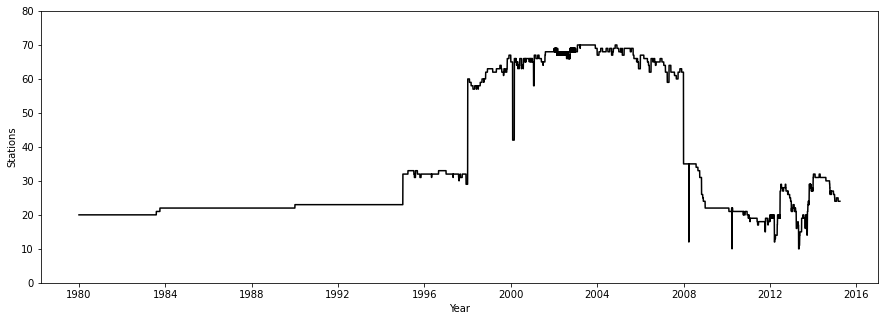

In [10]:
plt.figure(figsize=(15,5))
x = np.array(dff['Date'])
y = np.array(dff['Prec'])
plt.plot(x,y, 'k')
plt.xlabel("Year")
plt.ylabel("Stations")
plt.yticks([0,10,20,30,40,50,60,70,80])
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))
for idx, r in enumerate(dfg.Region.unique()):
    x = dfg[dfg['Region']==r]['year']
    y = np.trunc(dfg[dfg['Region']==r]['Prec']/365)
    if idx == 0: ax.bar(x,y,label=r)
    else: ax.bar(x,y,label=r, bottom=y_old)
    y_old = y
plt.legend()
plt.grid()
plt.plot()

In [10]:
regions = df['Region'].unique()
df['diff'] = df['precip_norris'] - df['Prec']
df['ae'] = abs(df['diff'])

for r in regions: 
    average = df['ae'][df['Region']==r].mean()
    print(r, f'{average:.2f}')

for r in regions:
    x = df[df['Region']==r]
    y = x['ae'][x['ae']!=0]
    print(r, f'{y.median():.2f}')
#     plt.hist(y, bins=50, log=True)
#     plt.show()

WestUIB 2.80
Langtang 8.64
EastUIB 4.31
WestUIB 1.79
Langtang 7.59
EastUIB 3.00


In [13]:
df.groupby(['Region','season']).mean()['ae']

KeyError: 'season'

In [ ]:
for r in regions:
    total_p = df[df['Region']==r].groupby(['Station']).mean()['Prec'].mean()
    print(r, f'{total_p:.2f}', f'{total_p*365:.0f}') 

In [11]:
df_b = df.groupby(['Region','Station']).mean()[['Prec','precip_norris','Z','rain_norris','X','Y']].reset_index()

In [12]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=1.5)

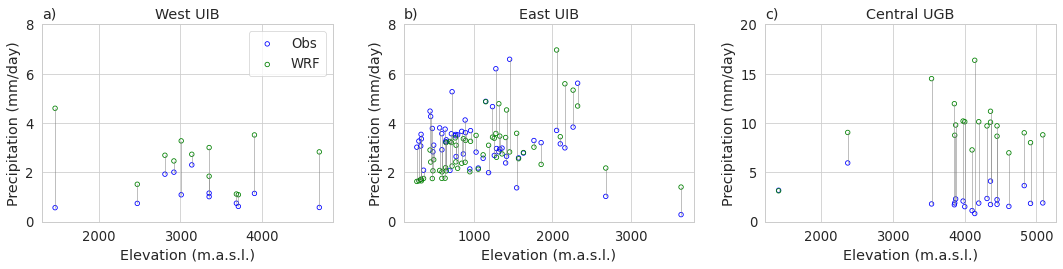

In [33]:
# regions = df_b.Region.unique()
regions = ['WestUIB','EastUIB','Langtang']

fig, axes = plt.subplots(1,3, figsize=(15,4))

for idx, (ax, r) in enumerate(zip(axes, regions)):
    
    df_a = df_b[df_b['Region']==r]

    x = df_a['Z'].values
    y = df_a['Prec'].values
    y2 = df_a['precip_norris'].values
    y3 = df_a['rain_norris'].values
    
    xp = np.linspace(min(x),max(x),100)
    z = np.polyfit(x, y, 2)
    z2 = np.polyfit(x, y2, 2)
    z3 = np.polyfit(x, y3, 2)

    p = np.poly1d(z)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)

    for i in range(len(x)):
        ax.plot([x[i],x[i]*1,x[i]],[y[i],(y[i]+y2[i])/2,y2[i]],color='grey',linewidth=0.5)
    
    ax.scatter(x,y,color='blue',label = 'Obs', s=20, facecolors='none')
    ax.scatter(x,y2,color='green',label = 'WRF',s=20, facecolors='none')

#     plt.scatter(x,y3,color='orange', marker='x',label = 'RCM rain')
    
#     plt.plot(xp,p(xp),'b--')
#     plt.plot(xp,p2(xp),'g--')
#     plt.plot(xp,p3(xp),'--', color='orange')
    
    if idx == 0: ax.set_ylim([0,8])
    if idx == 1: ax.set_ylim([0,8])
    if idx == 2: ax.set_ylim([0,20])
    ax.set_ylabel('Precipitation (mm/day)')
    ax.set_xlabel('Elevation (m.a.s.l.)')
    
    
    
#     plt.grid()
    if idx ==0: ax.legend()
    
    if r == 'EastUIB':
        reg = 'East UIB'
        ax.text(0, 1.09, f'b)', transform=ax.transAxes, verticalalignment='top')
    if r == 'WestUIB':
        reg = 'West UIB'
        ax.text(0, 1.09, f'a)', transform=ax.transAxes, verticalalignment='top')
    if r == 'Langtang':
        reg = 'Central UGB'
        ax.text(0, 1.09, f'c)', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(reg)
    
plt.tight_layout()
plt.savefig('../figures/precip_elev_curve.png',dpi=300)
plt.show()

In [20]:
import geopandas
import contextily as cx

In [21]:
gdf = geopandas.GeoDataFrame(df_b, geometry=geopandas.points_from_xy(df_b.X, df_b.Y), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

In [ ]:
gdf['AE_precip'] = abs(gdf['Prec'] - gdf['precip_norris'])
gdf['E_precip'] = (gdf['Prec'] - gdf['precip_norris'])

In [ ]:
fig, axes  = plt.subplot_mosaic('ZAAAAABBBBBBB;ZAAAAACCCCCCC;ZAAAAACCCCCCC', figsize=(20,10))
frames = ['A','B','C']
# # Convert axes dictionary keys to actual Axes objects
# axes = {k: plt.subplot(v) for k, v in axes.items()}

for i,r in enumerate(gdf.Region.unique()):
    ax = axes[frames[i]]
    gdf1 = gdf[gdf['Region']==r]
    
    vmin = gdf['E_precip'].min()
    vmax = gdf['E_precip'].max()
    
    x = gdf1.geometry.x.values
    y = gdf1.geometry.y.values
    t = gdf1.Station.values
    
    # Color code points by elevation
    sc = ax.scatter(gdf1.geometry.x, gdf1.geometry.y, c=gdf1['E_precip'], cmap='bwr', edgecolor='k', vmin=vmin, vmax=vmax, s=70)
   
    if i==0:
        cbar = plt.colorbar(sc, label='E (mm)', cax=plt.gcf().add_axes([0.04, 0.1, 0.02, 0.8]))
        cbar.ax.yaxis.set_ticks_position('left') # Manually adjust the colorbar position
   
    cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap, attribution=False)

    ax.tick_params(direction='in', which='both')
    ax.set_xticklabels([])
    ax.set_yticklabels([ax.get_yticks()])
    
#     for i, txt in enumerate(t):
#         ax.annotate(txt, (x[i]*1.0001, y[i]))
    
#     ax.tick_params(axis='x', pad=-15)
#     ax.tick_params(axis='x', pad=-20)
    ax.title.set_text(r)

ax = axes['Z']
# ax.axis('off')

# plt.tight_layout()
# plt.savefig('AE_plot_TonerLite.png',dpi=300)
plt.show()